# FINAL PROJECT

## Sentiment Analysis on Cryptocurrency vs. Open Banking vs. Banking

### Data Prep/Cleanup for Sentiment Analysis

In [115]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
from newsapi import NewsApiClient
from pathlib import Path

# For Sentiment Analysis
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
%matplotlib inline

# For Tokenizing
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# For Ngrams
from collections import Counter
from nltk import ngrams
from nltk.util import ngrams

# For Word Clouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10.0, 5.0]

# For Panel/Dashboard
import panel as pn
pn.extension()

# To Hide Warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piercerachel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [116]:
# Read api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API")

In [117]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [118]:
# Part 1
# Fetch the cryptocurrency news articles
crypto_news = newsapi.get_everything(
    q="cryptocurrency",
    language="en"
)

# Show the total number of news
crypto_news["totalResults"]

9494

In [119]:
# Export text to txt file for later use in AWS Comprehend
data_crypto = crypto_news["articles"]

all_content_crypto = []
for i in data_crypto:
    print(i["content"])
    all_content_crypto.append(i["content"])
    
filename = 'project3crypto.txt'
file_write = "C:/Users/piercerachel/Desktop/git/Project3/project3crypto.txt"

with open(file_write, 'w') as f:
    f.write(f"{all_content_crypto}\n")
    try:
        for item in all_content_crypto.append(i["content"]):
            f.write(item+"\n")
    except: 
        next

Illustration by James Bareham / The Verge

 


 More than $15 million has been donated so far More than $15 million in cryptocurrency has been donated to Ukrainian groups since Russia attacked the c… [+7442 chars]
SEC officials do not know the whereabouts of Satish Kumbhani, the founder of crypto trading platform BitConnect, who was charged
 last week with defrauding investors of $2.4 billion in a Ponzi schem… [+2634 chars]
On Tuesday, Ilya Lichtenstein and Heather Morgan were arrested in New York and accused of laundering a record $4.5 billion dollars worth of stolen cryptocurrency. In the 24 hours since, the cybersecu… [+4297 chars]
Even if you arent paying attention to Bitcoin and other cryptocurrencies, you might have noticed that their value plummeted last week, with the total value of the market tumbling from a high of $3 tr… [+4782 chars]
On February 3, the group started accepting ether donations on crypto crowdfunding platform Juicebox, eventually raising some $52 million. In e

In [120]:
# Create the Crypto sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [121]:
# Preview dataframe
crypto_df = create_df(crypto_news["articles"], "en")
crypto_df.head()

,title,description,text,date,language
0,How Ukrainians are fundraising in cryptocurrency,Millions of dollars of cryptocurrency have flo...,Illustration by James Bareham / The Verge\r\n\...,2022-02-26,en
1,BitConnect founder indicted by Justice Departm...,SEC officials do not know the whereabouts of S...,SEC officials do not know the whereabouts of S...,2022-03-02,en
2,The DOJ's $3.6B Seizure Shows How Hard It Is t...,A couple allegedly used a “laundry list” of te...,"On Tuesday, Ilya Lichtenstein and Heather Morg...",2022-02-09,en
3,Is the Crypto Bubble Going to Burst?,Even if you aren’t paying attention to Bitcoin...,Even if you arent paying attention to Bitcoin ...,2022-02-09,en
4,Assange's NFT Clock Sale Rides a Wave of DAO C...,The WikiLeaks founder raised $50 million for l...,"On February 3, the group started accepting eth...",2022-02-09,en


In [122]:
# Describe the Crypto Sentiment
# First get the sentiment calculation
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [123]:
# Second get the Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in crypto_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the Crypto DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
crypto_df = crypto_df.join(title_sentiment_df).join(text_sentiment_df)

crypto_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,How Ukrainians are fundraising in cryptocurrency,Millions of dollars of cryptocurrency have flo...,Illustration by James Bareham / The Verge\r\n\...,2022-02-26,en,0.0000,0.000,1.000,0.000,0,-0.4588,0.000,0.917,0.083,-1
1,BitConnect founder indicted by Justice Departm...,SEC officials do not know the whereabouts of S...,SEC officials do not know the whereabouts of S...,2022-03-02,en,0.3612,0.301,0.531,0.168,1,-0.2023,0.000,0.947,0.053,-1
2,The DOJ's $3.6B Seizure Shows How Hard It Is t...,A couple allegedly used a “laundry list” of te...,"On Tuesday, Ilya Lichtenstein and Heather Morg...",2022-02-09,en,-0.1027,0.000,0.887,0.113,-1,-0.7650,0.048,0.736,0.216,-1
3,Is the Crypto Bubble Going to Burst?,Even if you aren’t paying attention to Bitcoin...,Even if you arent paying attention to Bitcoin ...,2022-02-09,en,0.0000,0.000,1.000,0.000,0,0.5859,0.124,0.876,0.000,1
4,Assange's NFT Clock Sale Rides a Wave of DAO C...,The WikiLeaks founder raised $50 million for l...,"On February 3, the group started accepting eth...",2022-02-09,en,0.0000,0.000,1.000,0.000,0,0.3818,0.082,0.918,0.000,1


In [124]:
# Part 2
# Fetch the open banking news articles
openbanking_news = newsapi.get_everything(
    q="open banking",
    language="en"
)

# Show the total number of news
openbanking_news["totalResults"]

2995

In [125]:
# export text to txt file for later use in AWS Comprehend
data_open = openbanking_news["articles"]

all_content_open = []
for i in data_open:
    print(i["content"])
    all_content_open.append(i["content"])
    
filename = 'project3openbanking.txt'
file_write = "C:/Users/piercerachel/Desktop/git/Project3/project3openbanking.txt"

with open(file_write, 'w') as f:
    f.write(f"{all_content_open}\n")
    try:
        for item in all_content_open.append(i["content"]):
            f.write(item+"\n")
    except: 
        next

BENGALURU, Feb 18 (Reuters) - Indian shares edged lower on Friday, pressured by IT and banking stocks, with investors focused on the East-West standoff over Ukraine, which has roiled markets this wee… [+874 chars]
Although the UK pioneered open-
banking regulations (and popularized the term), Finicity CEO Steve Smith contends that the US has long been the engine of innovation driving the space forward.
In a … [+2619 chars]
ADDIS ABABA, Feb 22 (Reuters) - Ethiopia plans to open up its banking industry to foreign competition as soon as parliament passes policies permitting it, Prime Minister Abiy Ahmed said, flagging ref… [+1159 chars]
Relationship banking is a term you'll frequently find in many brick-and-mortar banks or national banks. If you're looking at the interest rates of a savings account, you might see relationship rates … [+3055 chars]
Mobile banking has recently risen in popularity and usage over the last year. Has it become better than traditional banking? We'll compare the 

In [126]:
# Create the Open Banking sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [127]:
# Preview dataframe
openbanking_df = create_df(openbanking_news["articles"], "en")
openbanking_df.head()

,title,description,text,date,language
0,"Indian shares open lower as IT, banks weigh - ...","Indian shares edged lower on Friday, pressured...","BENGALURU, Feb 18 (Reuters) - Indian shares ed...",2022-02-18,en
1,"Finicity co-founder talks open banking, fintec...",Finicity CEO Steve Smith talks about how socia...,Although the UK pioneered open-\r\nbanking reg...,2022-02-04,en
2,Ethiopia's Abiy tells banking sector to get re...,Ethiopia plans to open up its banking industry...,"ADDIS ABABA, Feb 22 (Reuters) - Ethiopia plans...",2022-02-22,en
3,"Relationship banking can offer special perks, ...",Banks use relationship banking to build relati...,Relationship banking is a term you'll frequent...,2022-02-04,en
4,"Mobile banking lets you bank from anywhere, bu...",Mobile banking lets you view or make transacti...,Mobile banking has recently risen in popularit...,2022-02-25,en


In [128]:
# Describe the Open Banking Sentiment
# First get the sentiment calculation
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [129]:
# Second get the Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in openbanking_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the Open Banking DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
openbanking_df = openbanking_df.join(title_sentiment_df).join(text_sentiment_df)

openbanking_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,"Indian shares open lower as IT, banks weigh - ...","Indian shares edged lower on Friday, pressured...","BENGALURU, Feb 18 (Reuters) - Indian shares ed...",2022-02-18,en,0.0000,0.177,0.645,0.177,0,0.1779,0.127,0.765,0.108,1
1,"Finicity co-founder talks open banking, fintec...",Finicity CEO Steve Smith talks about how socia...,Although the UK pioneered open-\r\nbanking reg...,2022-02-04,en,0.5106,0.292,0.708,0.000,1,0.6705,0.151,0.849,0.000,1
2,Ethiopia's Abiy tells banking sector to get re...,Ethiopia plans to open up its banking industry...,"ADDIS ABABA, Feb 22 (Reuters) - Ethiopia plans...",2022-02-22,en,0.3612,0.185,0.815,0.000,1,0.0000,0.000,1.000,0.000,0
3,"Relationship banking can offer special perks, ...",Banks use relationship banking to build relati...,Relationship banking is a term you'll frequent...,2022-02-04,en,0.4939,0.208,0.792,0.000,1,0.4588,0.091,0.909,0.000,1
4,"Mobile banking lets you bank from anywhere, bu...",Mobile banking lets you view or make transacti...,Mobile banking has recently risen in popularit...,2022-02-25,en,0.0000,0.000,1.000,0.000,0,0.7184,0.143,0.857,0.000,1


In [130]:
# Part 3
# Fetch the banking news articles
banking_news = newsapi.get_everything(
    q="banking",
    language="en"
)

# Show the total number of news
banking_news["totalResults"]

14840

In [131]:
# export text to txt file for later use in AWS Comprehend
data_banking = banking_news["articles"]

all_content_banking = []
for i in data_banking:
    print(i["content"])
    all_content_banking.append(i["content"])
       
filename = 'project3banking.txt'
file_write = "C:/Users/piercerachel/Desktop/git/Project3/project3banking.txt"

with open(file_write, 'w') as f:
    f.write(f"{all_content_banking}\n")
    try:
        for item in all_content_banking.append(i["content"]):
            f.write(item+"\n")
    except: 
        next

Our Banking CMO Report synthesizes interviews with 10 CMOs at some of the largest and most innovative banks, credit unions, and neobanks in the US and Canada.
Through our exclusive interviews, we pr… [+468 chars]
Mobile banking has recently risen in popularity and usage over the last year. Has it become better than traditional banking? We'll compare the two forms of banking so you can decide if one form of ba… [+6051 chars]
Bank mergers occur frequently, and even among big banks. Over the last year, a few notable bank mergers include PNC Bank's merger with BBVA; Truist Bank's merger with BB&amp;T and SunTrust; and First… [+2903 chars]
The news: US 
neobank SoFi has agreed to acquire Technisys, a cloud-based core-banking provider. The tie-up is valued at around $1.1 billion and is slated to close in Q2 2022.
… [+2943 chars]gence
DUBAI, Feb 25 (Reuters) - Afghanistan is inching closer towards economic collapse six months after the Taliban seized power, the Red Cross said on Friday, with 

In [132]:
# Create the Banking sentiment scores DataFrame
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [133]:
# Preview dataframe
banking_df = create_df(banking_news["articles"], "en")
banking_df.head()

,title,description,text,date,language
0,The Banking CMO Report Preview,Get an exclusive preview of the Banking CMO Re...,Our Banking CMO Report synthesizes interviews ...,2022-02-08,en
1,"Mobile banking lets you bank from anywhere, bu...",Mobile banking lets you view or make transacti...,Mobile banking has recently risen in popularit...,2022-02-25,en
2,Here's what to expect during a bank merger and...,A bank merger may affect your banking location...,"Bank mergers occur frequently, and even among ...",2022-03-03,en
3,SoFi's Technisys deal moves it closer to a 'on...,US neobank SoFi plans to acquire cloud-based c...,The news: US \r\nneobank SoFi has agreed to ac...,2022-02-23,en
4,Paralysed banking system pushing Afghanistan t...,Afghanistan is inching closer towards economic...,"DUBAI, Feb 25 (Reuters) - Afghanistan is inchi...",2022-02-25,en


In [134]:
# Describe the Banking Sentiment
# First get the sentiment calculation
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [135]:
# Second get the Sentiment scores dictionaries
title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
}
text_sent = {
    "text_compound": [],
    "text_pos": [],
    "text_neu": [],
    "text_neg": [],
    "text_sent": [],
}

# Get sentiment for the text and the title
for index, row in banking_df.iterrows():
    try:
        # Sentiment scoring with VADER
        title_sentiment = analyzer.polarity_scores(row["title"])
        title_sent["title_compound"].append(title_sentiment["compound"])
        title_sent["title_pos"].append(title_sentiment["pos"])
        title_sent["title_neu"].append(title_sentiment["neu"])
        title_sent["title_neg"].append(title_sentiment["neg"])
        title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

        text_sentiment = analyzer.polarity_scores(row["text"])
        text_sent["text_compound"].append(text_sentiment["compound"])
        text_sent["text_pos"].append(text_sentiment["pos"])
        text_sent["text_neu"].append(text_sentiment["neu"])
        text_sent["text_neg"].append(text_sentiment["neg"])
        text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass

# Attaching sentiment columns to the Open Banking DataFrame
title_sentiment_df = pd.DataFrame(title_sent)
text_sentiment_df = pd.DataFrame(text_sent)
banking_df = banking_df.join(title_sentiment_df).join(text_sentiment_df)

banking_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
0,The Banking CMO Report Preview,Get an exclusive preview of the Banking CMO Re...,Our Banking CMO Report synthesizes interviews ...,2022-02-08,en,0.0000,0.0,1.000,0.000,0,0.7620,0.191,0.809,0.000,1
1,"Mobile banking lets you bank from anywhere, bu...",Mobile banking lets you view or make transacti...,Mobile banking has recently risen in popularit...,2022-02-25,en,0.0000,0.0,1.000,0.000,0,0.7184,0.143,0.857,0.000,1
2,Here's what to expect during a bank merger and...,A bank merger may affect your banking location...,"Bank mergers occur frequently, and even among ...",2022-03-03,en,0.0000,0.0,1.000,0.000,0,0.0000,0.000,1.000,0.000,0
3,SoFi's Technisys deal moves it closer to a 'on...,US neobank SoFi plans to acquire cloud-based c...,The news: US \r\nneobank SoFi has agreed to ac...,2022-02-23,en,0.0000,0.0,1.000,0.000,0,0.7964,0.213,0.787,0.000,1
4,Paralysed banking system pushing Afghanistan t...,Afghanistan is inching closer towards economic...,"DUBAI, Feb 25 (Reuters) - Afghanistan is inchi...",2022-02-25,en,-0.4939,0.0,0.738,0.262,-1,-0.4939,0.000,0.906,0.094,-1


### Sentiment Analysis

<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

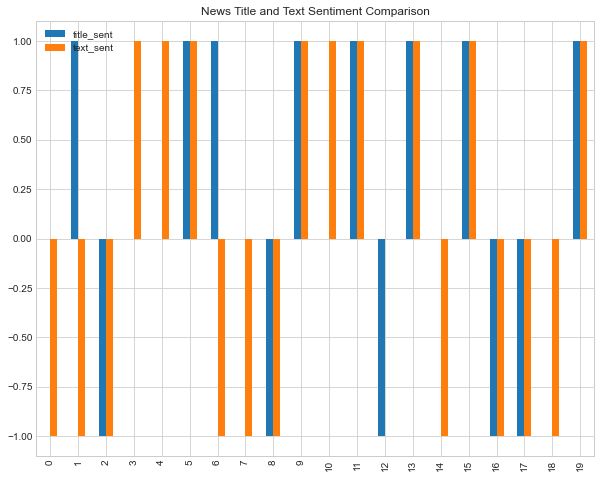

In [136]:
# Analyze Crypto Results:
crypto_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [137]:
# Get Stats on Crypto Dataframe
crypto_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.074210,0.116200,0.828400,0.055400,0.150000,0.006915,0.072250,0.858800,0.068950,-0.050000
std,0.293693,0.155245,0.156038,0.092068,0.812728,0.520486,0.071821,0.089299,0.072188,0.998683
min,-0.440400,0.000000,0.531000,0.000000,-1.000000,-0.765000,0.000000,0.662000,0.000000,-1.000000
25%,-0.025675,0.000000,0.703500,0.000000,-0.250000,-0.369700,0.000000,0.811500,0.000000,-1.000000
50%,0.000000,0.000000,0.819500,0.000000,0.000000,-0.101150,0.059500,0.887500,0.058000,-0.500000
75%,0.242025,0.229000,1.000000,0.123000,1.000000,0.435300,0.096000,0.922250,0.124750,1.000000
max,0.599400,0.423000,1.000000,0.286000,1.000000,0.726900,0.262000,1.000000,0.216000,1.000000


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

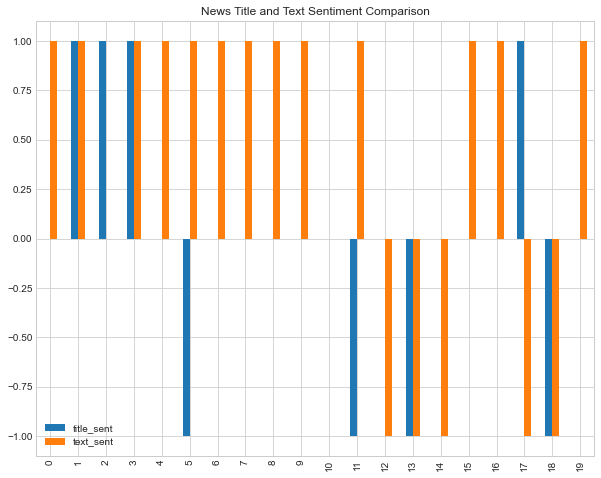

In [138]:
# Analyze Open Banking Results:
openbanking_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [139]:
# Get Stats on Open Banking Dataframe
openbanking_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,0.036195,0.090650,0.855400,0.053850,0.000000,0.189500,0.077850,0.888000,0.034050,0.40000
std,0.277321,0.130003,0.181291,0.099697,0.648886,0.442097,0.068969,0.071509,0.060801,0.88258
min,-0.440400,0.000000,0.526000,0.000000,-1.000000,-0.812600,0.000000,0.765000,0.000000,-1.00000
25%,0.000000,0.000000,0.692250,0.000000,0.000000,-0.019300,0.000000,0.845000,0.000000,-0.25000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.236950,0.062000,0.891000,0.000000,1.00000
75%,0.000000,0.168750,1.000000,0.037750,0.000000,0.491175,0.131000,0.940750,0.040750,1.00000
max,0.624900,0.459000,1.000000,0.308000,1.000000,0.831600,0.216000,1.000000,0.215000,1.00000


<AxesSubplot:title={'center':'News Title and Text Sentiment Comparison'}>

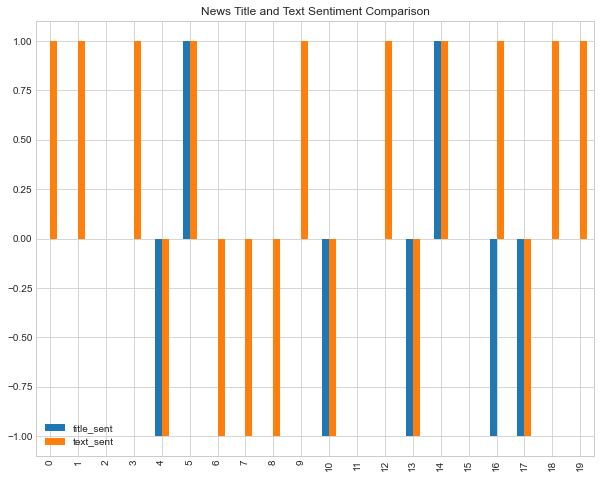

In [140]:
# Analyze Banking Results:
banking_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
)

In [141]:
# Get Stats on Banking Dataframe
banking_df.describe()

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.082050,0.038250,0.87565,0.086050,-0.150000,0.126935,0.092800,0.850600,0.056550,0.150000
std,0.254074,0.078779,0.16476,0.141867,0.587143,0.487351,0.078296,0.087198,0.057194,0.933302
min,-0.612400,0.000000,0.58800,0.000000,-1.000000,-0.718400,0.000000,0.707000,0.000000,-1.000000
25%,-0.032000,0.000000,0.73200,0.000000,-0.250000,-0.340975,0.040500,0.803500,0.000000,-1.000000
50%,0.000000,0.000000,1.00000,0.000000,0.000000,0.088950,0.078000,0.830000,0.062000,0.500000
75%,0.000000,0.000000,1.00000,0.189500,0.000000,0.553150,0.143750,0.908000,0.108000,1.000000
max,0.318200,0.216000,1.00000,0.412000,1.000000,0.796400,0.231000,1.000000,0.176000,1.000000


### Sentiment Analysis Conclusions:

**Q: Which concept (Cryptocurrency, Open Banking, or Banking) had the highest mean positive score?**  

A: Crypto had the highest mean title_pos score of 0.7845, while Banking had the highest mean text_pos score of 0.1163. Open Banking had the lowest.  
Banking = mean title_pos 0.1077, mean text_pos 0.1163  
Open Banking = mean title_pos 0.0950, mean text_pos 0.0711  
Crypto = mean title_pos 0.7845, mean text_pos 0.0841  

**Q: Which concept had the highest compound score?**  

A: Banking had the highest title_compound score of 0.8555 and the highest text_compound score of 0.7650. Both Crypto and Open Banking had lower similar scores.  
Banking = max title_compound 0.8555, max text_compound 0.7650  
Open Banking = max title_compound 0.6249, max text_compound 0.7003  
Crypto = max title_compound 0.6369, max text_compound 0.6808  

**Q. Which concept had the highest positive score?**  

A: Banking had the highest title_pos score of 0.7222 and the highest text_pos score of 0.2310.  Crypto had the lowest.  
Banking = max title_pos 0.7222, max text_pos 0.2310  
Open Banking = max title_pos 0.4590, max text_pos 0.1910  
Crypto = max title_pos 0.3440, max text_pos 0.1850  
  
*Note: Answers based on 2/22/22 code results.  Data will change daily and describe graphs may reflect updated numbers in results above.*


## Natural Language Processing (Cryptocurrency vs. Open Banking vs. Banking)

In [142]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [143]:
# Extract Article Content For Easier Analysis
data_crypto = crypto_news["articles"]
data_open = openbanking_news["articles"]
data_banking = banking_news["articles"]

all_content_crypto = []
for i in data_crypto:
    #print(i["content"])
    all_content_crypto.append(i["content"])
    
all_content_open = []
for i in data_open:
    #print(i["content"])
    all_content_open.append(i["content"])
    
all_content_banking = []
for i in data_banking:
    #print(i["content"])
    all_content_banking.append(i["content"])

In [144]:
# Updating to string
all_content_crypto = str(all_content_crypto)
all_content_open = str(all_content_open)
all_content_banking = str(all_content_banking)

In [145]:
# View tokenized crypto-related words
words_crypto = word_tokenize(all_content_crypto)
print(words_crypto)

['[', "'Illustration", 'by', 'James', 'Bareham', '/', 'The', 'Verge\\r\\n\\n', '\\n\\n\\n', 'More', 'than', '$', '15', 'million', 'has', 'been', 'donated', 'so', 'far', 'More', 'than', '$', '15', 'million', 'in', 'cryptocurrency', 'has', 'been', 'donated', 'to', 'Ukrainian', 'groups', 'since', 'Russia', 'attacked', 'the', 'c…', '[', '+7442', 'chars', ']', "'", ',', "'SEC", 'officials', 'do', 'not', 'know', 'the', 'whereabouts', 'of', 'Satish', 'Kumbhani', ',', 'the', 'founder', 'of', 'crypto', 'trading', 'platform', 'BitConnect', ',', 'who', 'was', 'charged\\r\\n', 'last', 'week', 'with', 'defrauding', 'investors', 'of', '$', '2.4', 'billion', 'in', 'a', 'Ponzi', 'schem…', '[', '+2634', 'chars', ']', "'", ',', "'On", 'Tuesday', ',', 'Ilya', 'Lichtenstein', 'and', 'Heather', 'Morgan', 'were', 'arrested', 'in', 'New', 'York', 'and', 'accused', 'of', 'laundering', 'a', 'record', '$', '4.5', 'billion', 'dollars', 'worth', 'of', 'stolen', 'cryptocurrency', '.', 'In', 'the', '24', 'hours', '

In [146]:
# View tokenized open banking-related words
words_open = word_tokenize(all_content_open)
print(words_open)

['[', "'BENGALURU", ',', 'Feb', '18', '(', 'Reuters', ')', '-', 'Indian', 'shares', 'edged', 'lower', 'on', 'Friday', ',', 'pressured', 'by', 'IT', 'and', 'banking', 'stocks', ',', 'with', 'investors', 'focused', 'on', 'the', 'East-West', 'standoff', 'over', 'Ukraine', ',', 'which', 'has', 'roiled', 'markets', 'this', 'wee…', '[', '+874', 'chars', ']', "'", ',', "'Although", 'the', 'UK\\xa0pioneered\\xa0open-\\r\\nbanking', 'regulations', '(', 'and', 'popularized', 'the', 'term', ')', ',', '\\xa0Finicity\\xa0CEO', 'Steve', 'Smith', 'contends', 'that', 'the', 'US', 'has', 'long', 'been', 'the', 'engine', 'of', 'innovation', 'driving', 'the', 'space', 'forward.\\r\\nIn', 'a', '…', '[', '+2619', 'chars', ']', "'", ',', "'ADDIS", 'ABABA', ',', 'Feb', '22', '(', 'Reuters', ')', '-', 'Ethiopia', 'plans', 'to', 'open', 'up', 'its', 'banking', 'industry', 'to', 'foreign', 'competition', 'as', 'soon', 'as', 'parliament', 'passes', 'policies', 'permitting', 'it', ',', 'Prime', 'Minister', 'Abiy'

In [147]:
# View tokenized banking-related words
words_banking = word_tokenize(all_content_banking)
print(words_banking)

['[', "'Our", 'Banking', 'CMO', 'Report', 'synthesizes', 'interviews', 'with', '10', 'CMOs', 'at', 'some', 'of', 'the', 'largest', 'and', 'most', 'innovative', 'banks', ',', 'credit', 'unions', ',', 'and', 'neobanks', 'in', 'the', 'US', 'and', 'Canada.\\r\\nThrough', 'our', 'exclusive', 'interviews', ',', 'we', 'pr…', '[', '+468', 'chars', ']', "'", ',', '``', 'Mobile', 'banking', 'has', 'recently', 'risen', 'in', 'popularity', 'and', 'usage', 'over', 'the', 'last', 'year', '.', 'Has', 'it', 'become', 'better', 'than', 'traditional', 'banking', '?', 'We', "'ll", 'compare', 'the', 'two', 'forms', 'of', 'banking', 'so', 'you', 'can', 'decide', 'if', 'one', 'form', 'of', 'ba…', '[', '+6051', 'chars', ']', "''", ',', '``', 'Bank', 'mergers', 'occur', 'frequently', ',', 'and', 'even', 'among', 'big', 'banks', '.', 'Over', 'the', 'last', 'year', ',', 'a', 'few', 'notable', 'bank', 'mergers', 'include', 'PNC', 'Bank', "'s", 'merger', 'with', 'BBVA', ';', 'Truist', 'Bank', "'s", 'merger', 'wit

In [148]:
# Adding Stop words
# NLTK list of stopwords
print(stopwords.words('english'))

languages = ['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek','hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']

for lang in languages:
    print("stopwords in:", lang, ":", len(stopwords.words(lang)))
    
sw = set(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [149]:
# Updating Stop Words Results for Crypto
first_result = [word.lower() for word in words_crypto if word.lower() not in sw]

# Updating Stop Words Results for Open Banking
first_result2 = [word.lower() for word in words_open if word.lower() not in sw]

# Updating Stop Words Results for Banking
first_result3 = [word.lower() for word in words_banking if word.lower() not in sw]

In [150]:
# Adding More Stop Words 

sw_addon = {'id', 'none', 'name', 'reuters', 'source', 'author', 'title', 'business', 'content'}
second_result = [word.lower() for word in words_crypto if word.lower() not in sw.union(sw_addon)]

sw_addon2 = {'id', 'none', 'name', 'reuters', 'source', 'author', 'title', 'business', 'content'}
second_result2 = [word.lower() for word in words_open if word.lower() not in sw.union(sw_addon2)]

sw_addon3 = {'id', 'none', 'name', 'reuters', 'source', 'author', 'title', 'business', 'content'}
second_result3 = [word.lower() for word in words_banking if word.lower() not in sw.union(sw_addon3)]

## NGrams, Frequency Analysis, and Word Clouds

In [151]:
# Generate the Crypto N-grams where N=2
def process_text(words_crypto):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(words_crypto))
    words_crypto = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words_crypto]
    output = [word.lower() for word in words_crypto if word.lower() not in sw]
    return output

In [152]:
# View processed text
processed_crypto = process_text(words_crypto)
print(processed_crypto)

['illustration', 'james', 'bareham', 'vergernn', 'nnn', 'million', 'donated', 'far', 'million', 'cryptocurrency', 'donated', 'ukrainian', 'groups', 'since', 'russia', 'attacked', 'c', 'chars', 'sec', 'officials', 'know', 'whereabouts', 'satish', 'kumbhani', 'founder', 'crypto', 'trading', 'platform', 'bitconnect', 'chargedrn', 'last', 'week', 'defrauding', 'investors', 'billion', 'ponzi', 'schem', 'chars', 'tuesday', 'ilya', 'lichtenstein', 'heather', 'morgan', 'arrested', 'new', 'york', 'accused', 'laundering', 'record', 'billion', 'dollars', 'worth', 'stolen', 'cryptocurrency', 'hours', 'since', 'cybersecu', 'chars', 'even', 'arent', 'paying', 'attention', 'bitcoin', 'cryptocurrencies', 'might', 'noticed', 'value', 'plummeted', 'last', 'week', 'total', 'value', 'market', 'tumbling', 'high', 'tr', 'chars', 'february', 'group', 'started', 'accepting', 'ether', 'donations', 'crypto', 'crowdfunding', 'platform', 'juicebox', 'eventually', 'raising', 'million', 'exchange', 'contributions',

In [153]:
# View bigram counts
crypto_bigram_counts = Counter(ngrams(processed_crypto, n=2))
print(dict(crypto_bigram_counts))

{('illustration', 'james'): 1, ('james', 'bareham'): 1, ('bareham', 'vergernn'): 1, ('vergernn', 'nnn'): 2, ('nnn', 'million'): 1, ('million', 'donated'): 1, ('donated', 'far'): 1, ('far', 'million'): 1, ('million', 'cryptocurrency'): 1, ('cryptocurrency', 'donated'): 1, ('donated', 'ukrainian'): 1, ('ukrainian', 'groups'): 1, ('groups', 'since'): 1, ('since', 'russia'): 1, ('russia', 'attacked'): 1, ('attacked', 'c'): 1, ('c', 'chars'): 1, ('chars', 'sec'): 1, ('sec', 'officials'): 1, ('officials', 'know'): 1, ('know', 'whereabouts'): 1, ('whereabouts', 'satish'): 1, ('satish', 'kumbhani'): 1, ('kumbhani', 'founder'): 1, ('founder', 'crypto'): 1, ('crypto', 'trading'): 1, ('trading', 'platform'): 1, ('platform', 'bitconnect'): 1, ('bitconnect', 'chargedrn'): 1, ('chargedrn', 'last'): 1, ('last', 'week'): 3, ('week', 'defrauding'): 1, ('defrauding', 'investors'): 1, ('investors', 'billion'): 1, ('billion', 'ponzi'): 1, ('ponzi', 'schem'): 1, ('schem', 'chars'): 1, ('chars', 'tuesday'):

In [154]:
# Generate the Open Banking N-grams where N=2
def process_text(words_open):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(words_open))
    words_open = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words_open]
    output = [word.lower() for word in words_open if word.lower() not in sw]
    return output

processed_open = process_text(words_open)
print(processed_open)

openbanking_bigram_counts = Counter(ngrams(processed_open, n=2))
print(dict(openbanking_bigram_counts))

['bengaluru', 'feb', 'reuters', 'indian', 'shares', 'edged', 'lower', 'friday', 'pressured', 'banking', 'stocks', 'investors', 'focused', 'eastwest', 'standoff', 'ukraine', 'roiled', 'markets', 'wee', 'chars', 'although', 'ukxapioneeredxaopenrnbanking', 'regulations', 'popularized', 'term', 'xafinicityxaceo', 'steve', 'smith', 'contends', 'us', 'long', 'engine', 'innovation', 'driving', 'space', 'forwardrnin', 'chars', 'addis', 'ababa', 'feb', 'reuters', 'ethiopia', 'plans', 'open', 'banking', 'industry', 'foreign', 'competition', 'soon', 'parliament', 'passes', 'policies', 'permitting', 'prime', 'minister', 'abiy', 'ahmed', 'said', 'flagging', 'ref', 'chars', 'relationship', 'banking', 'term', 'frequently', 'find', 'many', 'brickandmortar', 'banks', 'national', 'banks', 'looking', 'interest', 'rates', 'savings', 'account', 'might', 'see', 'relationship', 'rates', 'chars', 'mobile', 'banking', 'recently', 'risen', 'popularity', 'usage', 'last', 'year', 'become', 'better', 'traditional'

In [155]:
# Generate the Banking N-grams where N=2
def process_text(words_banking):
    sw = set(stopwords.words('english'))
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', str(words_banking))
    words_banking = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words_banking]
    output = [word.lower() for word in words_banking if word.lower() not in sw]
    return output

processed_banking = process_text(words_banking)
print(processed_banking)

banking_bigram_counts = Counter(ngrams(processed_banking, n=2))
print(dict(banking_bigram_counts))

['banking', 'cmo', 'report', 'synthesizes', 'interviews', 'cmos', 'largest', 'innovative', 'banks', 'credit', 'unions', 'neobanks', 'us', 'canadarnthrough', 'exclusive', 'interviews', 'pr', 'chars', 'mobile', 'banking', 'recently', 'risen', 'popularity', 'usage', 'last', 'year', 'become', 'better', 'traditional', 'banking', 'compare', 'two', 'forms', 'banking', 'decide', 'one', 'form', 'ba', 'chars', 'bank', 'mergers', 'occur', 'frequently', 'even', 'among', 'big', 'banks', 'last', 'year', 'notable', 'bank', 'mergers', 'include', 'pnc', 'bank', 'merger', 'bbva', 'truist', 'bank', 'merger', 'bb', 'amp', 'suntrust', 'first', 'chars', 'news', 'xaus', 'rnneobankxasofixahas', 'agreedxato', 'acquirexatechnisys', 'cloudbased', 'corebanking', 'provider', 'tieup', 'valued', 'around', 'billion', 'slated', 'close', 'q', 'rninsider', 'intelligencer', 'chars', 'dubai', 'feb', 'reuters', 'afghanistan', 'inching', 'closer', 'towards', 'economic', 'collapse', 'six', 'months', 'taliban', 'seized', 'pow

In [156]:
# Function token_count generates the top 10 words for a given concept
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [157]:
# Use token_count to get the top 10 bigrams/words for Crypto
print(dict(crypto_bigram_counts.most_common(10)))

{('last', 'week'): 3, ('vergernn', 'nnn'): 2, ('taking', 'advantage'): 2, ('reese', 'witherspoon'): 2, ('feb', 'reuters'): 2, ('illustration', 'james'): 1, ('james', 'bareham'): 1, ('bareham', 'vergernn'): 1, ('nnn', 'million'): 1, ('million', 'donated'): 1}


In [158]:
# Use token_count to get the top 10 bigrams/words for Open Banking
print(dict(openbanking_bigram_counts.most_common(10)))

{('feb', 'reuters'): 9, ('chars', 'milan'): 2, ('milan', 'feb'): 2, ('central', 'bank'): 2, ('personal', 'finance'): 2, ('sanctions', 'imposed'): 2, ('imposed', 'russia'): 2, ('bengaluru', 'feb'): 1, ('reuters', 'indian'): 1, ('indian', 'shares'): 1}


In [159]:
# Use token_count to get the top 10 bigrams/words for Banking
print(dict(banking_bigram_counts.most_common(10)))

{('feb', 'reuters'): 11, ('said', 'friday'): 3, ('banking', 'system'): 3, ('chars', 'feb'): 3, ('march', 'reuters'): 3, ('banking', 'stocks'): 3, ('chars', 'beijing'): 3, ('reuters', 'china'): 3, ('banking', 'insurance'): 3, ('insurance', 'regulator'): 3}


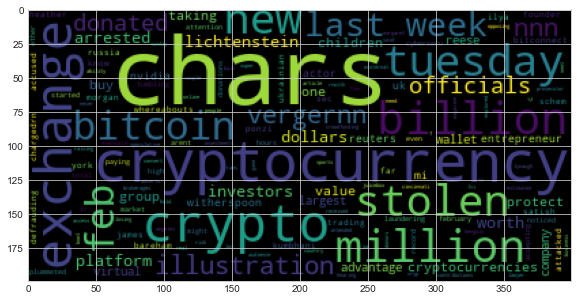

In [160]:
# Generate the Crypto word cloud
wc = WordCloud().generate(' '.join(processed_crypto))
plt.imshow(wc)

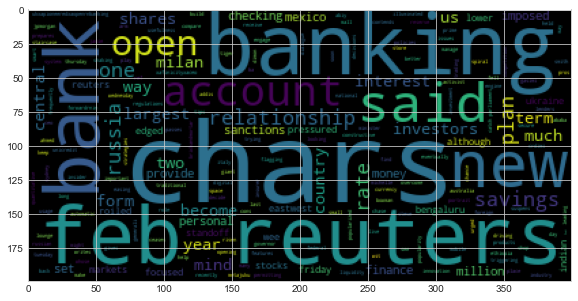

In [161]:
# Generate the Open Banking word cloud
wc = WordCloud().generate(' '.join(processed_open))
plt.imshow(wc)

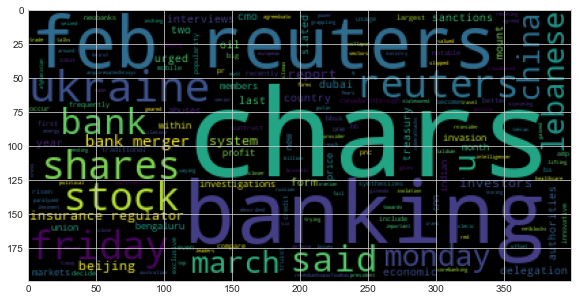

In [162]:
# Generate the Banking word cloud
wc = WordCloud().generate(' '.join(processed_banking))
plt.imshow(wc)

## Presentation Code - Dashboard

We created a dashboard for the presentation. The dashboard was saved as an html. Steps included creating markdown tabs, creating the dashboard, and saving to html.

In [20]:
markdown_titlepage = """
# Cryptocurrency, Open Banking, and Traditional Banking Sentiment Analysis
  
Presentation Date: March 5, 2022 
    
Prepared by Rachel and Margee
  
![Image](./Images/blockchainvstraditional.png)

"""

In [21]:
markdown1 = """
# Evolution of Banking  
  
- Banking has been around since the first currencies were minted and wealthy people wanted a safe place to store their money. 
- Ancient empires needed a functional financial system to facilitate trade, distribute wealth, and collect taxes. 
- Religious Temples became the earliest banks. They were seen as a safe place to store money and lent money (with interest).
- Roman Empire formalized banking within distinct buildings.  
- European Monarchs: Easy financing led kings into unnecessary extravagances, costly wars, and arms races with neighboring 
  kingdoms that would often lead to crushing debt.  
- In 1776, Adam Smith introduced the rise to Free-Market Banking. 
- Alexander Hamilton established a national bank, which created a uniform national currency backed by US Treasury securities, thus creating a liquid market.  
- Early 1800s to 1920 Merchant Banks - During this time banking saw numerous financial panics and bank runs.  
- In 1913, the US Government formed the Federal Reserve Bank to provide the country with a safe, flexible, and stable financial system.  
- World War II and the rise of Modern Banking.  Governments and Banks raised billions in capital to fund the war. These huge
  banks spanned global markets.  
- Banking goes Digital: Online banking, which in its earliest forms dates back to the 1980s and took off with the rise of 
  the internet in the mid-1990s.  Smartphones accelerated the trend. 
  
![Image](./Images/fed.jpg)

"""

In [22]:
markdown2 = """
# Innovation of Banking  
  
The Banking industry is no longer just a brick and mortor bank, we are moving towards blockchain technology and fintech 
innovation to provide better banking services to meet consumer demand.  
   
Let’s take a look back through a brief history of banking technology to see just how far we’ve come...  

- 1871 Wire Transfers - The first long-distance transfer of money used telegram technology for same-day transfers of money.  
- 1910 Routing numbers for Personal Checks - Slips were standardized in 1910 which allowed for universal processing.  
- 1950 Credit Cards - In the mid-20th century physical cards that could be used at multiple shops were introduced. 
- 1967 ATMs - Automated teller technology was introduced, but took decades to refine the technology to connect on a global network.  
- 1983 Online Banking - The first experiments in banking through the internet took place in the U.K. through televisions
  and using telephones to transfer money and pay bills.  As home internet access became more widespread in the mid-1990s, 
  so did online banking.
- 1996 EMV Chip - EMV technology is a system that connects a small chip in a credit or debit card to a payment terminal. 
- 2007 Mobile Banking - The launch of smartphones brought mobile banking into apps. 
- 2010s Mobile and P2P Payments - Technology such as ApplePay and GooglePay allows users to purchase goods in stores using smartphones.
- 2010s Voice Banking - Depending on device, can use voice to check bank balances, billing due dates, transactions, and pay bills.  
- AI and Banking - Artificial Intelligence enables banks to manage record-level high-speed data to receive valuable insights. 
- Open Banking - Open banking is the process of enabling third-party payment service and financial service providers to access 
  consumer banking information such as transactions and payment history.    
- Block Chain/Cryptocurrency - A blockchain is a decentralized ledger of all transactions across a peer-to-peer network (example: Cryptocurrency)
  
![Image](./Images/Evolution-of-Banking-Technology.png)

"""

In [23]:
markdown3 = """
# Banking Improvements and Challenges of Fintech Partnerships
  
- Two biggest improvements when banks partner with Fintechs are loan growth and new product development.
- Banks benefit from a Fintech's freedom to innovate and the agility to build tailored solutions for niche customer segments.
- Fintechs benefit from a Bank's dependability of established banking infrastructure, credibility with regulators, and a 
  trusting customer base.
- Technological challenges - integration with core and ancillary systems, digital banking platform integration, and lack of API experience.
- Additional challenges - insufficient organizational structure where individuals do not have necessary technical or operational skills.  
  
![Image](./Images/BankingandFintechpartnerships.png)
  
"""

In [24]:
markdown4 = """
# Bank Use Cases  
  
- *Cattle tracking with blockchain* - Blockchain tags to track cattle from the pasture to the meat case (FNB Omaha)
- *Bank crypto custody services* - Storing of private keys with help of sub-custodian NYDIG (U.S. Bank)
- *Visa/MC offering crypto conversion* - Cards linked to an account at a crypto platform
- *JP in the Metaverse/Onyx lounge* - Predict market opportunity of $1 trillion in virtual real estate
- *Milo* - Miami-based digital lender will soon offer a crypto mortgage to clients with digital assets
- *Tassat* - Instantaneous real-time transfer of Digital Dollars between two banks using blockchain technology
- *USDF Consortium* - Bank-Minted Tokenized Deposit Referencing Fiat Currency on Blockchain
- *Central Bank Digital Currencies (CBDCs)* - Nine launched, 15 Pilot, 16 in Development
- *Russia's use of Crypto to avoid sanctions* - Example, Binance will not block all Russian accounts despite Ukraine request
  
![Image](./Images/onyxlounge.jpg)

"""

In [25]:
markdown5 = """
# Banks currently using blockchain technology  
  
As of February 1, 2022, these are the top crypto-friendly banks:  
1. Bankprov  
2. Ally  
3. Revolut  
4. USAA  
5. Nuri  
6. Wirex  
  
![Image](./Images/cryptofriendlybanks.png)

"""

In [26]:
markdown6 = """
# Risks associated with new technologies in banking  
  
- BSA/AML, KYC
- Fair Lending
- Price risk
- Operational risks / Technology operations risk
- Strategic risk 
- Cyber security and incident reponse risk
- IT resiliency and business continuity risk
- Technology vendors and third party risk
- Data management risk
- Ineffective risk management
  
![Image](./Images/technologyriskinbanking.jpg)

"""

In [27]:
markdown7 = """
# Benefits of new technologies in banking  
  
- Faster payments
- Regulation/public trust
- Expansion of bank services/customer base
- Financial inclusion
- Innovation
- New business opportunities through new product offers
- Advanced machine learning mechanisms to better understand customer behavior and offer an improved experience
- Advanced Security
- Reduce Costs
  
![Image](./Images/technologybenefits.png)

"""

In [28]:
markdown8 = """
# Project Overview and Hypothesis  
  
Analyze sentiment across three main concepts: Crypto, Open Banking, and Traditional Banking.  

1. Does the public have a positive, negative, or neutral sentiment surrounding crypto in banking?
2. Does the public have a positive, negative, or neutral sentiment surrounding open banking?
3. Does the public have a positive, negative, or neutral sentiment surrounding traditional banking?
4. How do these three concepts compare (sentiment analysis)?
5. How do our sentiment analysis results compare to AWS Comprehend?  
  
*Hypothesis*:  
The banking industry is more risk averse and less supportive of cryptocurrency (more negative sentiment). 
While some banks are offering crypto services, we believe that banks are more comfortable partnering with fintechs 
to offer crypto services and other innovative technologies rather than developing and offering them through the bank.  
We predict that open banking will have the most favorable sentiment of the three concepts.

![Image](./Images/sentimentimage.jpeg)

"""

In [29]:
markdown9 = """
# What is Crypto vs. Open Banking vs. Traditional Banking  
   
*Cryptocurrency* - a digital currency in which transactions are verified and records maintained by a decentralized system  
using cryptography, rather than by a centralized authority.  
  
*Open Banking* - a banking practice that provides third-party financial service providers open access to consumer banking,  
transaction, and other financial data from banks and non-bank financial institutions through the use of APIs.  
  
*Traditional Banking* - The most common banks are the brick and mortar banks, which are banks with branches.   
Many of them offer online banking, but the online services are optional.  
  
![Image](./Images/Legacy-to-open-banking-transformation.jpg)  
  
![Image](./Images/fiatvscrypto.jpg)  

"""

In [30]:
markdown10 = """
# Techniques Used to Accomplish Objective  
  
- IDEs including Spyder and Jupyter Lab
- Applicable pandas libraries, such as nltk
- AWS Comprehend/Sagemaker  
   
![Image](./Images/pythonnltk.jfif)  
  
![Image](./Images/comprehend.gif)

"""

In [31]:
markdown11 = """
# Sentiment Analysis Results
  
- Cryptocurrency = Neutral/Slightly Positive
- Open Banking = Positive
- Banking = Positive  
  
*Crypto Plot*    
![Image](./Images/cryptoplot.png)  
*Open Banking Plot*  
![Image](./Images/openbankingplot.png)  
*Banking Plot*  
![Image](./Images/bankingplot.png)  
  
*Data Results*  
  
- Crypto had the highest mean title_pos score, while Banking had the highest mean text_pos score. Open Banking had the lowest.  
- Banking had the highest title_compound and the highest text_compound scores of 0.7650. Both Crypto and Open Banking had lower similar scores.  
- Banking had the highest title_pos and the highest text_pos scores.  Crypto had the lowest.  
  
![Image](./Images/cryptodescribe.png)  
![Image](./Images/openbankingdescribe.png)  
![Image](./Images/bankingdescribe.png)  

"""

In [32]:
markdown12 = """
# Ngrams and Frequency Analysis Results (Word Clouds!)
  
Crypto Word Cloud   
  
![Image](./Images/cryptowordcloud.png)
  
Open Banking Word Cloud   
  
![Image](./Images/openbankingwordcloud.png)  
  
Banking Word Cloud  
  
![Image](./Images/bankingwordcloud.png)

"""

In [33]:
markdown13 = """
# AWS Comprehend Demo
Amazon Comprehend is a natural language processing (NLP) service on Amazon Web Services that uses machine learning to uncover valuable insights and connections in text. 
On the AWS Platform we used Amazon S3, Amazon Comprehend and SageMaker to process text to extract key phrases, entities and sentiment analysis for further analysis.  
  
- Amazon S3 stores the Data  
- Amazon Comprehend processes the Data  
- Amazon SageMaker creates the Notebooks to write the code  
  
*AWS Presentation/Demo*

"""

In [34]:
markdown14 = """
# Overall Conclusions
  
Our hypothesis that Open Banking would achieve the highest sentiment was inaccurate, while our prediction that crypto would achieve the lowest sentiment was accurate. Based on our sentiment analysis, the most positive sentiment scores were 
tied to Traditional Banking. However, these results could be skewed based on overlap between Banking/Open Banking news articles. Crypto had the lowest sentiment across most analysis results.  
  
**Questions Answered:**  
1. Does the public have a positive, negative, or neutral sentiment surrounding crypto in banking?  
Neutral/Slightly Positive  
2. Does the public have a positive, negative, or neutral sentiment surrounding open banking?  
Positive  
3. Does the public have a positive, negative, or neutral sentiment surrounding traditional banking?  
Positive  
4. How do these three concepts compare (sentiment analysis)?  
Based on our analysis, traditional banking has the highest positive scores in most categories.  Crypto and Open Banking were mixed, with some positive, some negative, but crypto was clearly the lowest overall.  
5. How does our sentiment analysis results compare to AWS Comprehend?  
AWS Comprehend results were neutral across all three concepts.  
  
*What do YOU think is the future of banking?*  
  
![Image](./Images/futurebanking.jpg)

"""

In [35]:
markdown15 = """
# Data Issues, Improvements, and Potential Next Steps
  
- NewsAPI limited character content in articles obtained
- Stop words may not include all necessary stop words
- Open banking and banking articles may overlap  
  
Potential next steps could include changing "Open Banking" to "Fintechs" to determine if results would be clearer, rather than having the potential for overlap with Banking. Also finding a better news API with more content would result in more accurate sentiment analyses.

"""

In [36]:
markdown_end = """
# THE END
    
![Image](./Images/digitalcash.jpg)

"""

In [37]:
#Create Dashboard
pn.Tabs(
    ("Project 3",markdown_titlepage),
    ("Evolution of Banking",markdown1),
    ("Innovation of Banking",markdown2),
    ("Improvements and Challenges",markdown3),
    ("Bank Use Cases",markdown4),
    ("Banks",markdown5),
    ("Risks",markdown6),
    ("Benefits",markdown7),
    ("Project Overview",markdown8),
    ("Background",markdown9),
    ("Techniques",markdown10),
    ("Sentiment Analysis",markdown11),
    ("Ngrams/Frequency Analysis",markdown12),
    ("AWS Demo",markdown13),
    ("Conclusion",markdown14),
    ("Data Issues",markdown15),
    ("THE END",markdown_end)
       )

Tabs
    [0] Markdown(str, name='Project 3')
    [1] Markdown(str, name='Evolution of Banking')
    [2] Markdown(str, name='Innovation of Banking')
    [3] Markdown(str, name='Improvements a...)
    [4] Markdown(str, name='Bank Use Cases')
    [5] Markdown(str, name='Banks')
    [6] Markdown(str, name='Risks')
    [7] Markdown(str, name='Benefits')
    [8] Markdown(str, name='Project Overview')
    [9] Markdown(str, name='Background')
    [10] Markdown(str, name='Techniques')
    [11] Markdown(str, name='Sentiment Analysis')
    [12] Markdown(str, name='Ngrams/Frequency A...)
    [13] Markdown(str, name='AWS Demo')
    [14] Markdown(str, name='Conclusion')
    [15] Markdown(str, name='Data Issues')
    [16] Markdown(str, name='THE END')

In [38]:
#Create an html of the dashboard for presentation purposes once finalized
pn.Tabs(
    ("Project 3",markdown_titlepage),
    ("Evolution of Banking",markdown1),
    ("Innovation of Banking",markdown2),
    ("Improvements and Challenges",markdown3),
    ("Bank Use Cases",markdown4),
    ("Banks",markdown5),
    ("Risks",markdown6),
    ("Benefits",markdown7),
    ("Project Overview",markdown8),
    ("Background",markdown9),
    ("Techniques",markdown10),
    ("Sentiment Analysis",markdown11),
    ("Ngrams/Frequency Analysis",markdown12),
    ("AWS Demo",markdown13),
    ("Conclusion",markdown14),
    ("Data Issues",markdown15),
    ("THE END",markdown_end)
       ).save("Project3_Presentation.html", embed=True)